In [29]:
import math
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
# constants
data_src = "data/cleaned/tournament_m1_results_short_formatted.csv"
joe_data_src = "data/cleaned/tournament_results_short_formatted.csv"

In [31]:
# load data
tournament_results = pd.read_csv(data_src)

In [32]:
# some constants for later use
groups = list(set(tournament_results['player_names']))
groups.sort(key=lambda x: int(x.split(' ')[-1]))

def exclude_groups(groups):
	groups_excluded = ['Group 2', 'Group 4', 'Group 5', 'Group 8']
	groups_filtered = [g for g in groups if g not in groups_excluded]
	
	groups_filtered.sort(key=lambda x: int(x.split(' ')[-1]))
	return groups_filtered


maps = list(set(tournament_results['map']))

In [33]:
tournament_results.head()

,player_names,map,skills,scores,player_states,penalties,timeout_count,error_count,total_time_sorted
0,Group 10,maps/g4/n.json,10,10,1,0,0,1,0.038419
1,Group 10,maps/g4/n.json,10,10,1,0,0,1,0.038422
2,Group 10,maps/g4/n.json,10,10,1,0,0,1,0.037853
3,Group 10,maps/g4/n.json,10,10,1,0,0,1,0.037846
4,Group 10,maps/g4/n.json,10,10,1,0,0,1,0.034455


## Helper Functions

In [34]:
def annotate(plot, x, y):
	for p in plot.patches:
		plot.annotate(f'{p.get_height():.1f}', (p.get_x() + x, p.get_height() + y))

In [35]:
def save_fig(df_plot, path):
	df_plot.get_figure().savefig(path, bbox_inches='tight')

## Compare Time Taken for our player on GCP vs M1

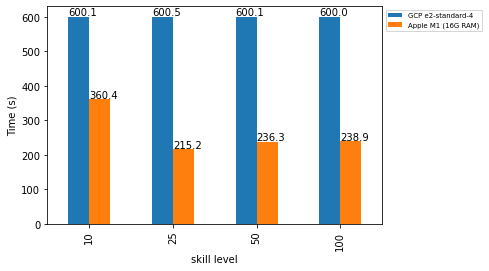

In [36]:
# m1 results -> tournament_results
joe_results = pd.read_csv(joe_data_src)

filter_condition = (joe_results['map'] == 'maps/g2/mwc_swirly.json') & (joe_results['player_names'] == 'Group 1')
gcp_times = joe_results[filter_condition].filter(['skills', 'total_time_sorted']).groupby('skills').mean().assign(machine=lambda _: 'GCP e2-standard-4')

m1_filter_condition = (tournament_results['map'] == 'maps/g2/mwc_swirly.json') & (tournament_results['player_names'] == 'Group 1')
m1_times = tournament_results[m1_filter_condition].filter(['skills', 'total_time_sorted']).groupby('skills').mean().assign(machine=lambda _: 'Apple M1 (16G RAM)')

# dataframe
gcp_m1_time_comparison = pd.concat([gcp_times, m1_times]).reset_index().pivot(index='skills', columns='machine', values='total_time_sorted').reset_index()

# plot and save
plot = gcp_m1_time_comparison.plot.bar(
	x='skills', y=['GCP e2-standard-4', 'Apple M1 (16G RAM)'],
	xlabel='skill level', ylabel='Time (s)')
plot.legend(loc='best', fontsize='x-small', bbox_to_anchor=(1, 1))
annotate(plot, 0, 5)
save_fig(plot, 'graphs/gcp_vs_m1_time.png')

## Timeout Statistics

- total number of timeouts by group
- total number of timeouts by skill level for each group

In [37]:
total_timeouts_by_group = tournament_results.filter(['player_names', 'timeout_count']).groupby(['player_names']).sum()
total_timeouts_by_group_and_skill_level = tournament_results.filter(['player_names', 'skills', 'timeout_count']).groupby(['skills', 'player_names']).sum()

In [38]:
print(total_timeouts_by_group_and_skill_level.head())

                     timeout_count
skills player_names               
10     Group 1                  15
       Group 10                 12
       Group 2                  51
       Group 3                   0
       Group 4                  63


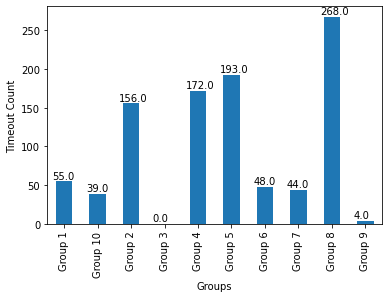

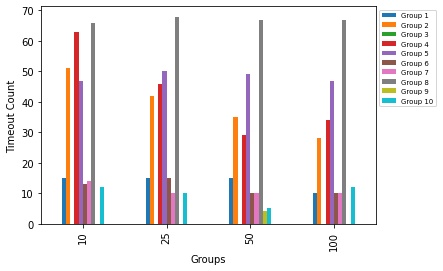

In [39]:
timeouts_plot = total_timeouts_by_group.plot.bar(xlabel='Groups', ylabel='Timeout Count', legend=False)
annotate(timeouts_plot, -0.1, 3)
save_fig(timeouts_plot, 'graphs/m1_timeouts.png')

timeouts_df = total_timeouts_by_group_and_skill_level.reset_index().pivot(index='skills', columns='player_names', values='timeout_count').reset_index()
timeouts_plot = timeouts_df.plot.bar(
	x='skills', y=groups,
	xlabel='Groups', ylabel='Timeout Count')
timeouts_plot.legend(fontsize='x-small', bbox_to_anchor=(1,1))
save_fig(timeouts_plot, 'graphs/m1_timouts_by_skill.png')

## Penalty Statistics

- penalties per attempt over all skills
- penalties per attempt for each skill

In [40]:
total_penalties_by_group = tournament_results.filter(['player_names', 'penalties']).groupby(['player_names']).sum()
total_penalties_by_group_and_skill_level = tournament_results.filter(['player_names', 'skills', 'penalties']).groupby(['skills', 'player_names']).sum()

If a player times out, it might not have made any moves. Thus, a player who times out often will likely to have fewer penalties.

To remove the effect of timeouts in our penalty frequency analysis, we adjust the total number of penalties by dividing it over the total games attempted by each player.

Here we calculate some aggregate statistics:
- total number of games attempted by each group's player
- total number of games attempted by each group's player broken down by skill level

In [41]:
total_games_played_by_group = tournament_results.filter(['player_names', 'scores']).groupby(['player_names']).count()
total_games_played_by_group_and_skill_level = tournament_results.filter(['player_names', 'skills', 'scores']).groupby(['skills', 'player_names']).count()


total_games_attempted_by_group = tournament_results.filter(['player_names', 'timeouts']).groupby(['player_names'], group_keys=False).apply(lambda x: 1 - x)
total_games_attempted_by_group_and_skill_level = tournament_results.filter(['player_names', 'skills', 'timeouts']).groupby(['skills', 'player_names']).apply(lambda x: 1 - x)

# print(total_games_attempted_by_group)
# print(total_games_attempted_by_group_and_skill_level.head(20))
game_played_stats = total_games_played_by_group.merge(total_timeouts_by_group, on='player_names', copy=False)
game_played_stats = game_played_stats.rename(columns={"scores": "total", "timeout_count": "timeouts"})
game_played_stats = game_played_stats.assign(attempted=lambda x: x.total - x.timeouts)


game_played_stats_by_skill = total_games_played_by_group_and_skill_level.merge(total_timeouts_by_group_and_skill_level, on=['skills', 'player_names'], copy=False)
game_played_stats_by_skill = game_played_stats_by_skill.rename(columns={"scores": "total", "timeout_count": "timeouts"})
game_played_stats_by_skill = game_played_stats_by_skill.assign(attempted=lambda x: x.total - x.timeouts)

# print(game_played_stats)
# print(game_played_stats_by_skill)

Now we calculate the number of penalties per attempt (by skill level):

In [42]:
total_penalties_per_attempt = game_played_stats.merge(total_penalties_by_group, on="player_names", copy=False).assign(penalties_per_attempt=lambda x: x.penalties/x.attempted)
total_penalties_per_attempt_by_skill = game_played_stats_by_skill.merge(total_penalties_by_group_and_skill_level, on=["skills", "player_names"], copy=False).assign(penalties_per_attempt=lambda x: x.penalties/x.attempted)

In [43]:
total_penalties_per_attempt = total_penalties_per_attempt.filter(['player_names', 'penalties_per_attempt'])
total_penalties_per_attempt_by_skill = total_penalties_per_attempt_by_skill.filter(['skills', 'player_names', 'penalties_per_attempt'])

Plotting the graphs...

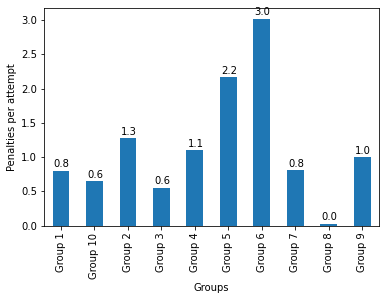

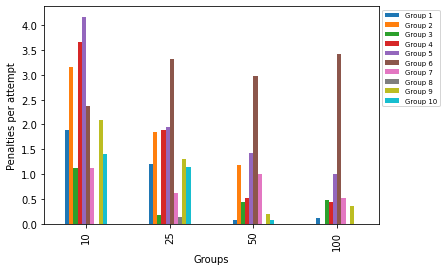

In [44]:
penalties_plot = total_penalties_per_attempt.reset_index().plot.bar(
	x='player_names', y='penalties_per_attempt',
	xlabel='Groups', ylabel='Penalties per attempt', legend=False)
annotate(penalties_plot, 0.03, 0.05)
save_fig(penalties_plot, 'graphs/m1_penalties.png')


df_penalties_by_skill = total_penalties_per_attempt_by_skill.reset_index().pivot(index='skills', columns='player_names', values='penalties_per_attempt').reset_index()
penalties_by_skill_plot = df_penalties_by_skill.plot.bar(
	x='skills', y=groups,
	xlabel='Groups', ylabel='Penalties per attempt')
penalties_by_skill_plot.legend(fontsize='x-small', bbox_to_anchor=(1,1))
save_fig(penalties_by_skill_plot, 'graphs/m1_penalties_by_skill.png')

## Note

From now on, we'll be excluding Group 2, 4, 5, 8 from comparison since they timed out in more than half of the runs. It would be unfair to compare our player reran on M1 against their player ran on GCP with a much less powerful CPU.

In [45]:
def exclude_rows(df):
	groups_excluded = ['Group 2', 'Group 4', 'Group 5', 'Group 8']

	for g in groups_excluded:
		df = df[df['player_names'] != g]

	return df

## Scores

We are interested in two metrics:

- average score for different skill levels

In [46]:
# 1. group by: player_names, skills
tournament_results = exclude_rows(tournament_results)

avg_scores_by_group = tournament_results.filter(['player_names', 'scores']).groupby(['player_names']).mean()
avg_scores_by_skill_level_and_group = tournament_results.filter(['player_names', 'skills', 'scores']).groupby(['skills', 'player_names']).mean()

<AxesSubplot:title={'center':'Average Number of Strokes Per Group: All Skill Levels'}, xlabel='Groups', ylabel='Stroke Count'>

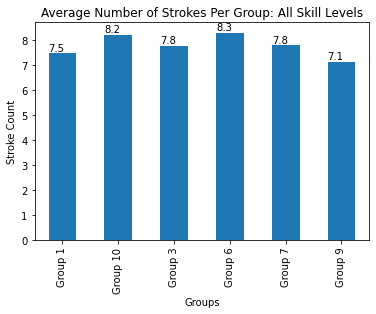

In [47]:
# print(avg_scores_by_skill_level_and_group.tail(20))
# print(avg_scores_by_group)

scores_plot = avg_scores_by_group.reset_index().plot.bar(
	x="player_names", y="scores",
	xlabel='Groups', ylabel='Stroke Count',
	title='Average Number of Strokes Per Group: All Skill Levels',
	legend=False)
annotate(scores_plot, 0, 0.1)
save_fig(scores_plot, 'graphs/m1_avg_scores.png')

scores_plot

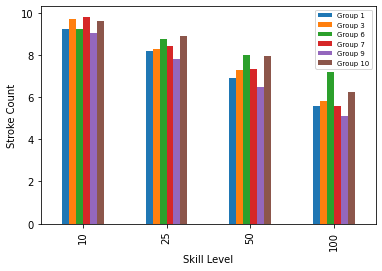

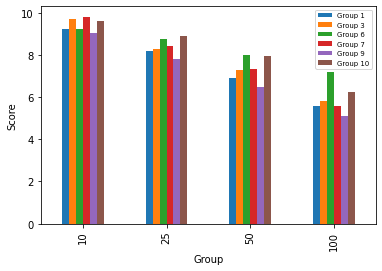

In [48]:
scores_by_skill_df = avg_scores_by_skill_level_and_group.reset_index().pivot(index="skills", columns="player_names", values="scores").reset_index()
scores_plot = scores_by_skill_df.plot.bar(
	x="skills", y=exclude_groups(groups),
	xlabel='Skill Level', ylabel='Stroke Count')
scores_plot.legend(loc='best', fontsize='x-small', bbox_to_anchor=(1,1))
save_fig(scores_plot, 'graphs/avg_score_by_skill.png')

scores_by_skill_df = avg_scores_by_skill_level_and_group.reset_index().pivot(index="skills", columns="player_names", values="scores").reset_index()
avg_scores_by_skill_plot = scores_by_skill_df.plot.bar(
	x="skills", y=exclude_groups(groups),
	xlabel='Group', ylabel='Score')
avg_scores_by_skill_plot.legend(loc='best', fontsize='x-small')
save_fig(avg_scores_by_skill_plot, 'graphs/m1_avg_scores_by_skill.png')

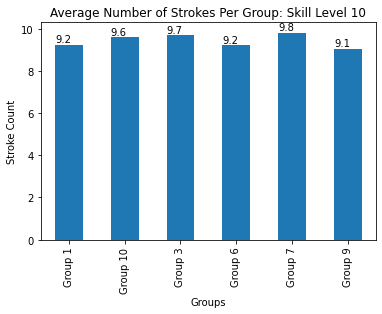

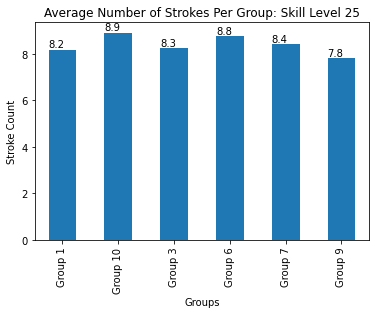

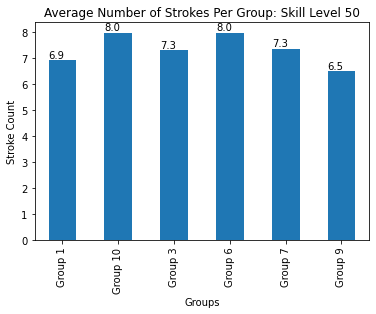

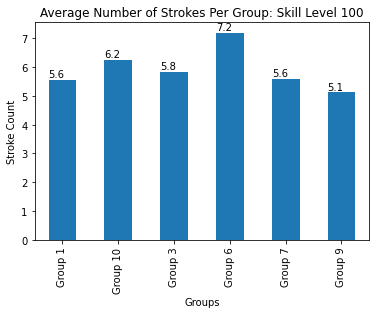

In [49]:
scores_by_skill_df = avg_scores_by_skill_level_and_group.reset_index()
for skill in [10, 25, 50, 100]:
	score_by_skill_plot = scores_by_skill_df[scores_by_skill_df['skills'] == skill].filter(['player_names', 'scores']).plot.bar(
		x="player_names", y="scores",
		xlabel='Groups', ylabel='Stroke Count',
		title=f'Average Number of Strokes Per Group: Skill Level {skill}',
		legend=False)
	annotate(score_by_skill_plot, 0, 0.1)
	save_fig(score_by_skill_plot, f'graphs/m1_avg_scores_skill_{skill}.png')

Let's calculate some per map statistics:

- average score by group
- average score by skill and group

In [50]:
base_df = tournament_results.filter(['player_names', 'map', 'skills', 'scores'])
avg_scores_by_map = base_df.filter(['player_names', 'map', 'scores']).groupby(['map', 'player_names']).mean()
avg_scores_by_map_skill = base_df.groupby(['map', 'skills', 'player_names']).mean()

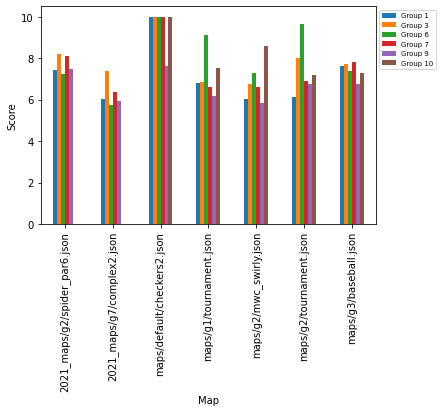

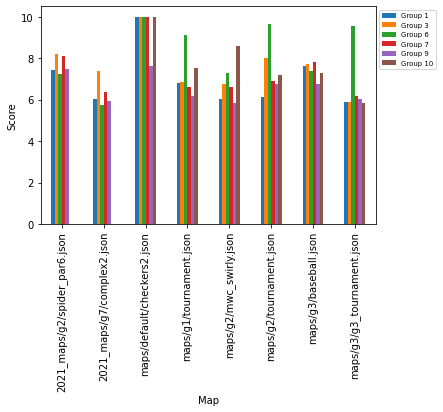

In [51]:
# print(avg_scores_by_map)
# print(avg_scores_by_map_skill)

avg_scores_map_df = avg_scores_by_map.reset_index().pivot(index='map', columns='player_names', values='scores').reset_index()
total_maps = len(avg_scores_map_df.index)
hd, tl = math.floor(total_maps/2), math.ceil(total_maps/2)

# plot
scores_by_map_1 = avg_scores_map_df.head(hd).plot.bar(
	x='map', y=exclude_groups(groups),
	xlabel='Map', ylabel='Score')
scores_by_map_1.legend(loc='best', fontsize='x-small', bbox_to_anchor=(1,1))

scores_by_map_2 = avg_scores_map_df.head(tl).plot.bar(
	x='map', y=exclude_groups(groups),
	xlabel='Map', ylabel='Score')
scores_by_map_2.legend(loc='best', fontsize='x-small', bbox_to_anchor=(1,1))

# save figures
save_fig(scores_by_map_1, 'graphs/m1_avg_scores_by_map1_7.png')
save_fig(scores_by_map_2, 'graphs/m1_avg_scores_by_map8_15.png')

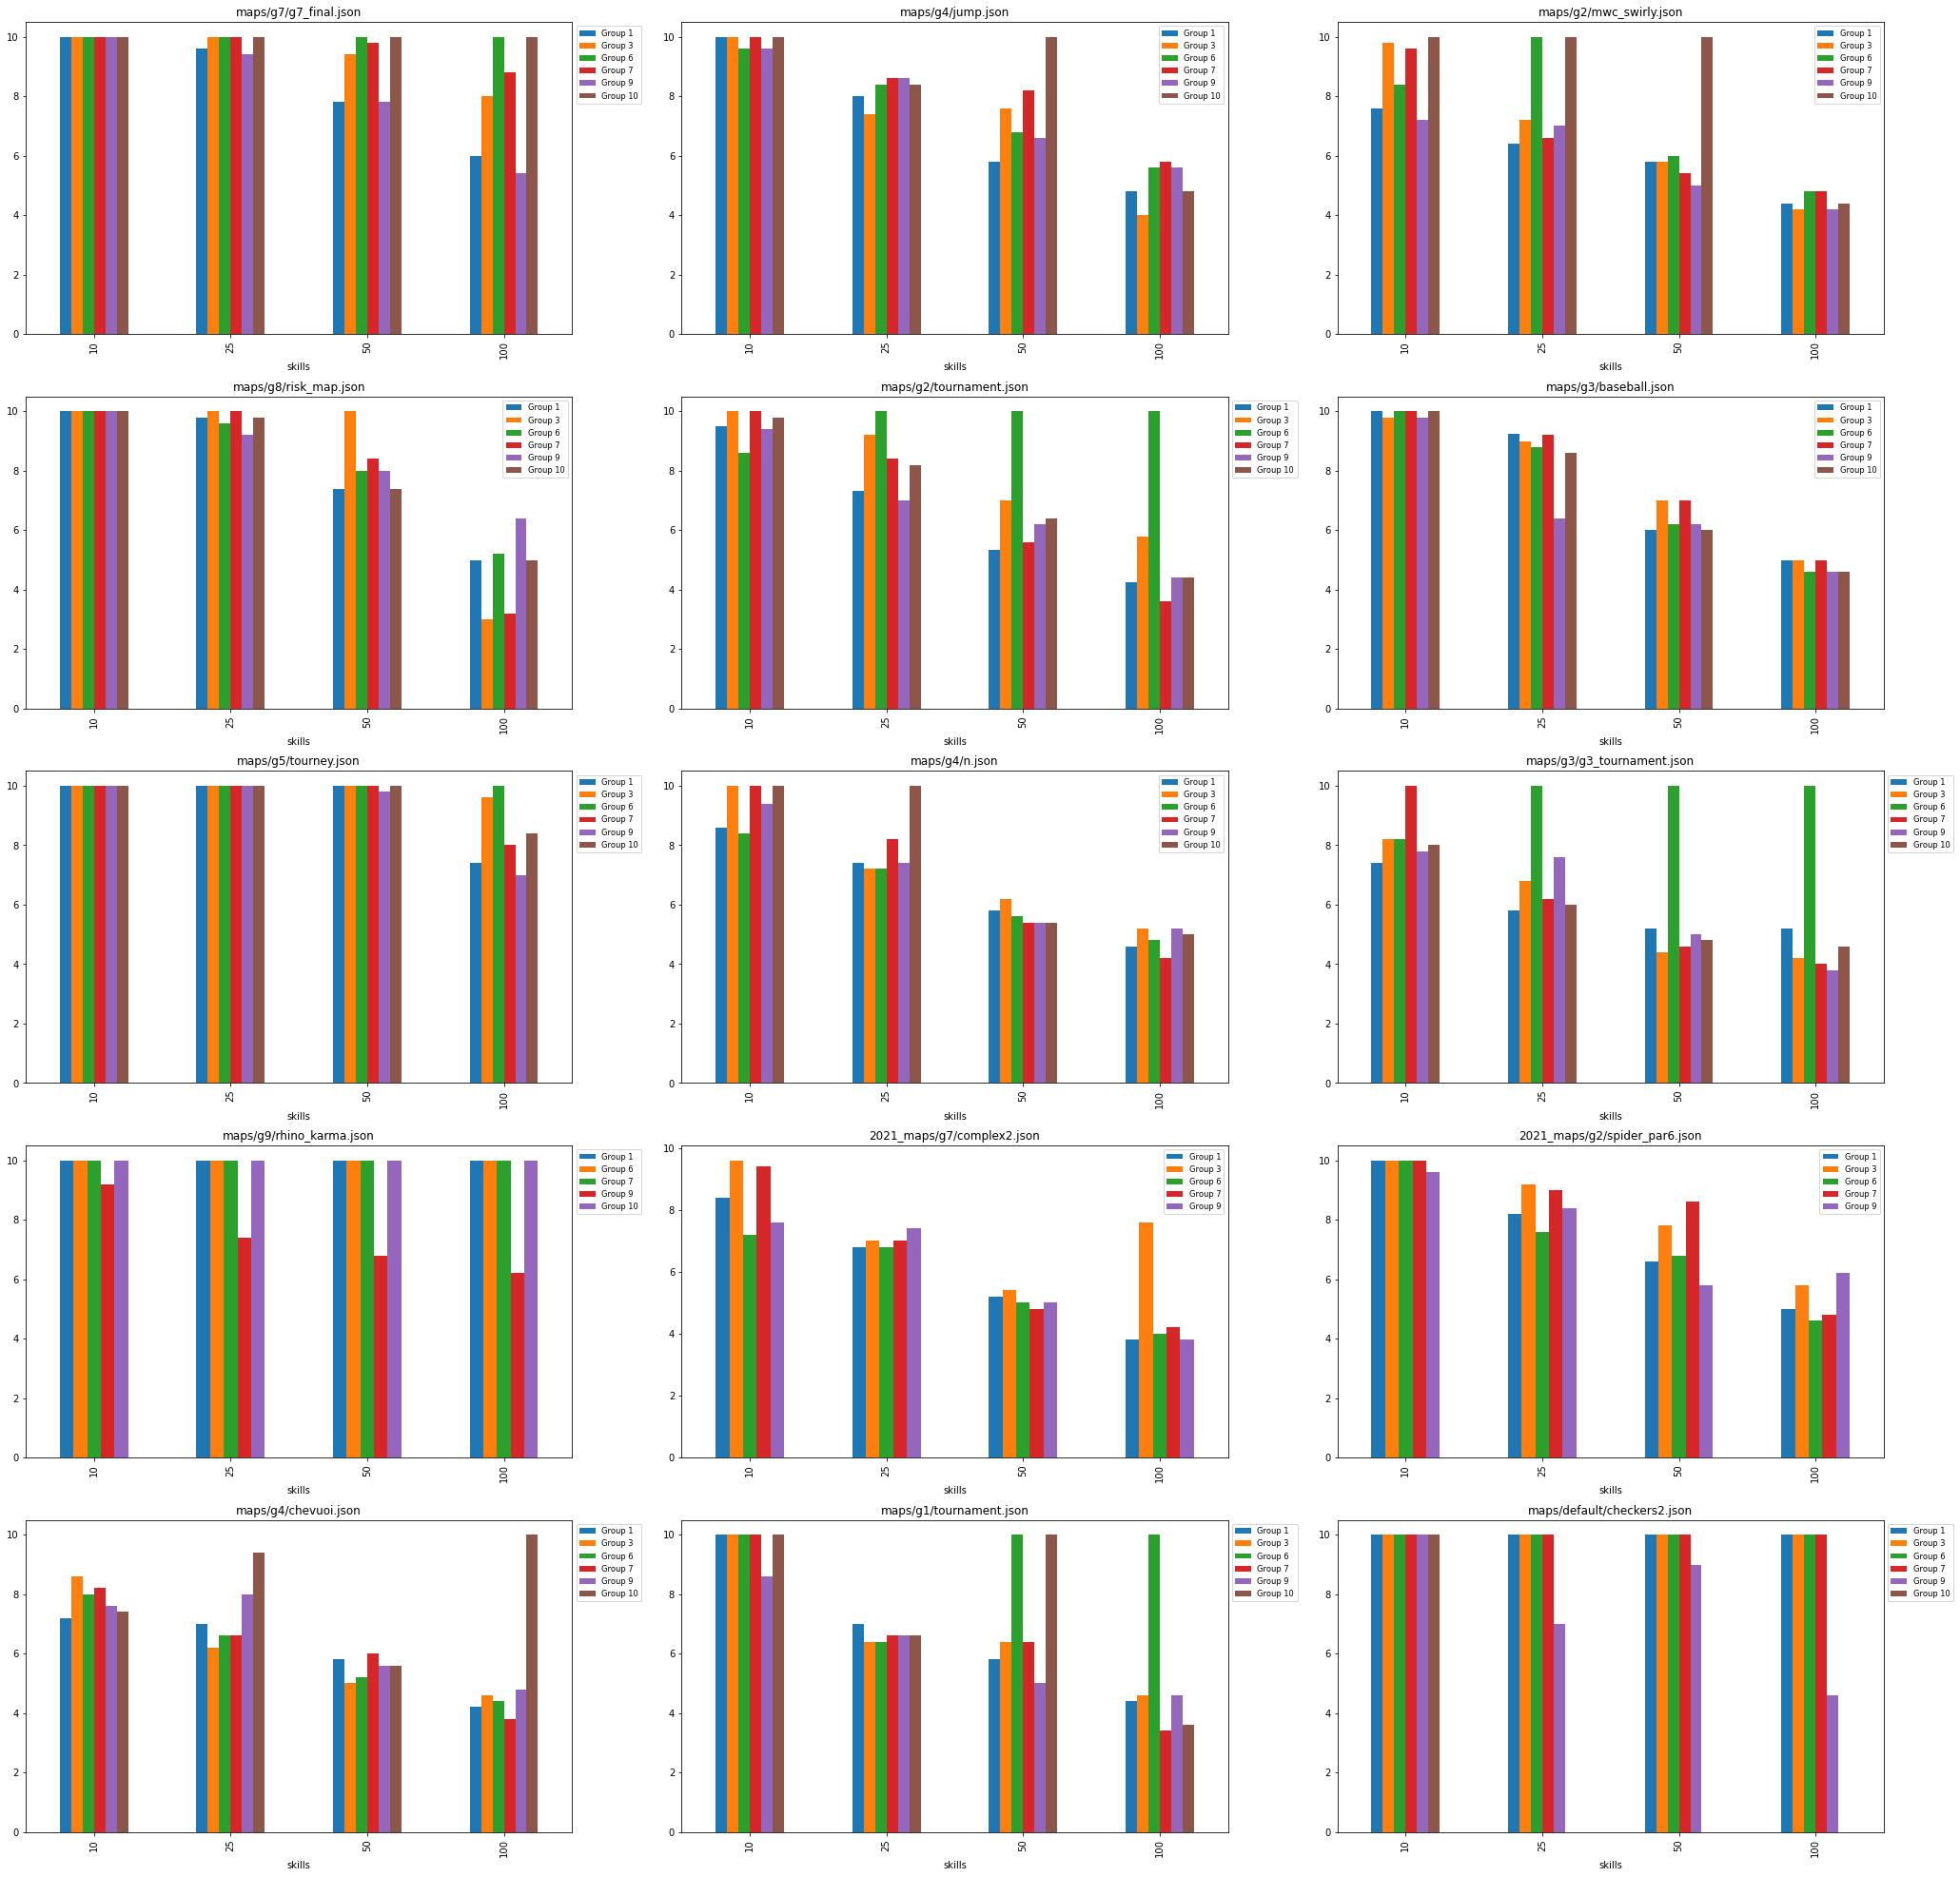

In [52]:
avg_scores_map_skill_df = avg_scores_by_map_skill.reset_index()

nrow, ncol = 5, 3
map_fig, map_axes = plt.subplots(nrow, ncol, figsize=(35, 35))

count = 0
for tmap in maps:
	map_df = avg_scores_map_skill_df[avg_scores_map_skill_df['map'] == tmap]
	map_groups = list(set(map_df['player_names'].values.tolist()))
	map_groups.sort(key=lambda x: int(x.split(' ')[-1]))

	map_df = map_df.pivot(index='skills', columns='player_names', values='scores').reset_index()
	map_df.plot.bar(x='skills', y=exclude_groups(map_groups), title=tmap, ax=map_axes[count // ncol, count % ncol])
	map_axes[count // ncol, count % ncol].legend(loc='best', fontsize='small', bbox_to_anchor=(1, 1))
	count += 1

map_fig.savefig('graphs/m1_score_by_map_skill.png')